In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import time
import math
import copy
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
data = pd.read_csv("./data_banknote_authentication.txt", header=None)
m, n = data.shape
# seperate into input and output features
X, Y = data.values[:, :-1], data.values[:, -1]
Y = LabelEncoder().fit_transform(Y)
# split into train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

X_train = X_train.T
X_test = X_test.T

In [3]:
def relu(Z):
    return np.maximum(Z, 0)

def tanh(Z):
    return np.tanh(Z)

def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def relu_deriv(Z):
    return Z > 0

def tanh_deriv(Z):
    return 1-np.tanh(Z)**2

def sigmoid_deriv(Z):
    sig = 1/(1+np.exp(-Z))
    return sig * (1 - sig)

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

In [4]:
class NeuralNetwork:
    def __init__(self, layer_sizes, epochs, alpha, activations):
            self.layer_sizes = layer_sizes
            self.num_iters = epochs
            self.learning_rate = alpha
            self.activations = activations
            self.params = {}
            self.last = len(self.layer_sizes)
            self.init_params()
            self.accuracy = None
            self.X = None
            self.Y = None
            self.AccuracyList = []
            self.AccuracyEpochList = []
            self.AccuracyTimeList = []
            self.totalTime = None
            self.startTime = None
            self.stopTime = None
            
    def __repr__(self):
        return f"ANN Hyperparameters\nLayers: {self.layer_sizes}\nIterations: {self.num_iters} \
                \nLearning rate: {self.learning_rate}\nActivations: {self.activations}"
    
    # Initalize the network with random weights and biases
    def init_params(self):
        # Initalize the network with random weights and biases 
        params = self.params
        for i in range(1, self.last):
            params[f'W{i}'] = np.random.rand(self.layer_sizes[i], self.layer_sizes[i-1]) - 0.5
            params[f'B{i}'] = np.random.rand(self.layer_sizes[i],1) - 0.5

    def forward_propagation(self, X):
        # Pass X through the network 
        params = self.params
        for i in range(1, self.last):
            if i==1:
                # For first layer compute dot with x
                output = params[f'W{i}'].dot(X) + params[f'B{i}']
            else: 
                # For all other layers compute with output of prev layer
                output = params[f'W{i}'].dot(params[f'A{i-1}']) + params[f'B{i}']
          
            # For all other layers use the activ_fnc initalized in constructor
            activ_fnc = self.activations[i-1]
            activations = globals()[activ_fnc](output)
            
            params[f'Z{i}'] = output
            params[f'A{i}'] = activations


    def backward_propagation(self, X, Y):
        ohY = one_hot(Y)
        params = self.params
        
        for i in range(self.last - 1, 0, -1):
            if(i == self.last - 1):
                # For final layer calculate how wrong net is and compute gradients for weights and biases
                dZ =  params[f'A{i}'] - ohY
                params[f'dZ{i}'] = dZ
                params[f'dW{i}'] = 1 / m * dZ.dot(params[f'A{i-1}'].T)
                params[f'dB{i}'] = 1 / m * np.sum(dZ)
            elif (i == 1):
                # For first layer compute the gradients for weights and biases with input of dataset
                dZ = params[f'W{i+1}'].T.dot(params[f'dZ{i+1}']) * globals()[f'{self.activations[i-1]}_deriv'](params[f'Z{i}'])
                params[f'dZ{i}'] = dZ
                params[f'dW{i}'] = 1 / m * dZ.dot(X.T)
                params[f'dB{i}'] = 1 / m * np.sum(dZ)
            else: 
                # For all other layers compute the gradients for weights and biases with the output of the prev layer
                dZ = params[f'W{i+1}'].T.dot(params[f'dZ{i+1}']) * globals()[f'{self.activations[i-1]}_deriv'](params[f'Z{i}'])
                params[f'dZ{i}'] = dZ
                params[f'dW{i}'] = 1 / m * dZ.dot(params[f'A{i-1}'].T)
                params[f'dB{i}'] = 1 / m * np.sum(dZ)

    
    def update_params(self, alpha):
        # Update all layers based on the gradients calculated in back prop
        params = self.params
        for i in range(1, self.last):
            params[f'W{i}'] =  params[f'W{i}'] - self.learning_rate * params[f'dW{i}']
            params[f'B{i}'] =  params[f'B{i}'] - self.learning_rate * params[f'dB{i}']

    def make_predictions(self, X):
        self.forward_propagation(X)
        predictions = self.get_predictions()
        return predictions

    def test_predictions(self, i):
        curr = X_train[:, i, None]
        print("label ", Y_train[i])
        print("predicted ", self.make_predictions(curr)[0])

    def get_predictions(self):
        return np.argmax(self.params[f'A{self.last-1}'], 0)

    def get_accuracy(self, predictions, Y):
        return np.sum(predictions == Y) / Y.size
    
    def train(self, X, Y, printAccuracy=False):
        start = time.perf_counter()
        self.X = X
        self.Y = Y
        for i in range(self.num_iters):
            self.forward_propagation(X)
            self.backward_propagation(X, Y)
            self.update_params(self.learning_rate)
       
            predictions = self.get_predictions()
            self.accuracy = self.get_accuracy(predictions, Y)
            self.AccuracyList.append(self.accuracy)
            self.AccuracyEpochList.append((i,self.accuracy))
            self.AccuracyTimeList.append(((time.perf_counter() - start), self.accuracy))
       
            # Print accuracy every 10 iterations
            if(printAccuracy==True):
                if i % 1 == 0:
                    print("Iteration: ", i)
                    print('Accuracy: ', self.accuracy)
        stop = time.perf_counter()
        self.totalTime = stop - start
        self.startTime = start
        self.stopTime = stop
        return self.params
     
    def change_layers(self, layers):
        old_accuracy = self.accuracy
        self.layer_sizes = layers
        self.init_params()
        self.train(self.X, self.Y, printAccuracy=False)
        print(f"Old test accuracy: {old_accuracy}\nNew test accuracy: {self.accuracy}")    

    def change_activations(self, activations):
        old_accuracy = self.accuracy
        self.activations = activations
        self.train(self.X, self.Y, printAccuracy=False)
        print(f"Old test accuracy: {old_accuracy}\nNew test accuracy: {self.accuracy}")

    def change_epochs(self, epochs):
        old_accuracy = self.accuracy
        self.num_iters = epochs
        self.train(self.X, self.Y, printAccuracy=False)
        print(f"Old test accuracy: {old_accuracy}\nNew test accuracy: {self.accuracy}")
    
    def change_learningRate(self, alpha):
        old_accuracy = self.accuracy
        self.learning_rate = alpha
        self.train(self.X, self.Y, printAccuracy=False)
        print(f"Old test accuracy: {old_accuracy}\nNew test accuracy: {self.accuracy}")
        
    def view_accuracyEpoch(self):
        sns.set(rc={'figure.figsize':(15,8)})
        df = pd.DataFrame(self.AccuracyEpochList, columns=["Epochs", "Accuracy"])
        sns.lineplot(data=df, x="Epochs", y="Accuracy", ci=None)
    
    def view_accuracyTime(self):
        sns.set(rc={'figure.figsize':(15,8)})
        df = pd.DataFrame(self.AccuracyTimeList, columns=["Time", "Accuracy"])
        sns.lineplot(data=df, x="Time", y="Accuracy", ci=None)
        
   

In [5]:
nn = NeuralNetwork([4,10,10,2], 500, 0.10, ['relu','relu','sigmoid'])

In [6]:
x = nn.train(X_train, Y_train, printAccuracy=True)

Iteration:  0
Accuracy:  0.559375
Iteration:  1
Accuracy:  0.559375
Iteration:  2
Accuracy:  0.559375
Iteration:  3
Accuracy:  0.559375
Iteration:  4
Accuracy:  0.559375
Iteration:  5
Accuracy:  0.559375
Iteration:  6
Accuracy:  0.559375
Iteration:  7
Accuracy:  0.559375
Iteration:  8
Accuracy:  0.559375
Iteration:  9
Accuracy:  0.559375
Iteration:  10
Accuracy:  0.559375
Iteration:  11
Accuracy:  0.559375
Iteration:  12
Accuracy:  0.559375
Iteration:  13
Accuracy:  0.559375
Iteration:  14
Accuracy:  0.559375
Iteration:  15
Accuracy:  0.559375
Iteration:  16
Accuracy:  0.559375
Iteration:  17
Accuracy:  0.559375
Iteration:  18
Accuracy:  0.559375
Iteration:  19
Accuracy:  0.559375
Iteration:  20
Accuracy:  0.559375
Iteration:  21
Accuracy:  0.5666666666666667
Iteration:  22
Accuracy:  0.5760416666666667
Iteration:  23
Accuracy:  0.5927083333333333
Iteration:  24
Accuracy:  0.6041666666666666
Iteration:  25
Accuracy:  0.6239583333333333
Iteration:  26
Accuracy:  0.64375
Iteration:  27
A

Iteration:  305
Accuracy:  1.0
Iteration:  306
Accuracy:  1.0
Iteration:  307
Accuracy:  1.0
Iteration:  308
Accuracy:  1.0
Iteration:  309
Accuracy:  1.0
Iteration:  310
Accuracy:  1.0
Iteration:  311
Accuracy:  1.0
Iteration:  312
Accuracy:  1.0
Iteration:  313
Accuracy:  1.0
Iteration:  314
Accuracy:  1.0
Iteration:  315
Accuracy:  1.0
Iteration:  316
Accuracy:  1.0
Iteration:  317
Accuracy:  1.0
Iteration:  318
Accuracy:  1.0
Iteration:  319
Accuracy:  1.0
Iteration:  320
Accuracy:  1.0
Iteration:  321
Accuracy:  1.0
Iteration:  322
Accuracy:  1.0
Iteration:  323
Accuracy:  1.0
Iteration:  324
Accuracy:  1.0
Iteration:  325
Accuracy:  1.0
Iteration:  326
Accuracy:  1.0
Iteration:  327
Accuracy:  1.0
Iteration:  328
Accuracy:  1.0
Iteration:  329
Accuracy:  1.0
Iteration:  330
Accuracy:  1.0
Iteration:  331
Accuracy:  1.0
Iteration:  332
Accuracy:  1.0
Iteration:  333
Accuracy:  1.0
Iteration:  334
Accuracy:  1.0
Iteration:  335
Accuracy:  1.0
Iteration:  336
Accuracy:  1.0
Iteratio

In [7]:
preds = nn.make_predictions(X_test)

In [8]:
nn.test_predictions(1)

label  0
predicted  0


In [9]:
nn.test_predictions(2)

label  1
predicted  1


### Hyperparameter Investigation

In [10]:
nn_lr = NeuralNetwork([4,10,10,2], 500, 0.1, ['relu','relu','sigmoid'])

In [11]:
lr = nn_lr.train(X_train, Y_train, printAccuracy=True)

Iteration:  0
Accuracy:  0.4479166666666667
Iteration:  1
Accuracy:  0.6229166666666667
Iteration:  2
Accuracy:  0.6479166666666667
Iteration:  3
Accuracy:  0.6833333333333333
Iteration:  4
Accuracy:  0.7125
Iteration:  5
Accuracy:  0.73125
Iteration:  6
Accuracy:  0.7510416666666667
Iteration:  7
Accuracy:  0.7645833333333333
Iteration:  8
Accuracy:  0.7770833333333333
Iteration:  9
Accuracy:  0.7875
Iteration:  10
Accuracy:  0.8114583333333333
Iteration:  11
Accuracy:  0.8208333333333333
Iteration:  12
Accuracy:  0.8239583333333333
Iteration:  13
Accuracy:  0.8354166666666667
Iteration:  14
Accuracy:  0.8447916666666667
Iteration:  15
Accuracy:  0.8614583333333333
Iteration:  16
Accuracy:  0.8802083333333334
Iteration:  17
Accuracy:  0.9041666666666667
Iteration:  18
Accuracy:  0.925
Iteration:  19
Accuracy:  0.9364583333333333
Iteration:  20
Accuracy:  0.95
Iteration:  21
Accuracy:  0.9572916666666667
Iteration:  22
Accuracy:  0.9625
Iteration:  23
Accuracy:  0.9666666666666667
Iter

Iteration:  284
Accuracy:  1.0
Iteration:  285
Accuracy:  1.0
Iteration:  286
Accuracy:  1.0
Iteration:  287
Accuracy:  1.0
Iteration:  288
Accuracy:  1.0
Iteration:  289
Accuracy:  1.0
Iteration:  290
Accuracy:  1.0
Iteration:  291
Accuracy:  1.0
Iteration:  292
Accuracy:  1.0
Iteration:  293
Accuracy:  1.0
Iteration:  294
Accuracy:  1.0
Iteration:  295
Accuracy:  1.0
Iteration:  296
Accuracy:  1.0
Iteration:  297
Accuracy:  1.0
Iteration:  298
Accuracy:  1.0
Iteration:  299
Accuracy:  1.0
Iteration:  300
Accuracy:  1.0
Iteration:  301
Accuracy:  1.0
Iteration:  302
Accuracy:  1.0
Iteration:  303
Accuracy:  1.0
Iteration:  304
Accuracy:  1.0
Iteration:  305
Accuracy:  1.0
Iteration:  306
Accuracy:  1.0
Iteration:  307
Accuracy:  1.0
Iteration:  308
Accuracy:  1.0
Iteration:  309
Accuracy:  1.0
Iteration:  310
Accuracy:  1.0
Iteration:  311
Accuracy:  1.0
Iteration:  312
Accuracy:  1.0
Iteration:  313
Accuracy:  1.0
Iteration:  314
Accuracy:  1.0
Iteration:  315
Accuracy:  1.0
Iteratio

#### Informal

In [12]:
ann = NeuralNetwork([4,3,2,2], 10, 1, ['relu','relu','sigmoid'])

In [13]:
ann.train(X_train, Y_train, printAccuracy=False);

In [14]:
# Original Hyperparameters
ann

ANN Hyperparameters
Layers: [4, 3, 2, 2]
Iterations: 10                 
Learning rate: 1
Activations: ['relu', 'relu', 'sigmoid']

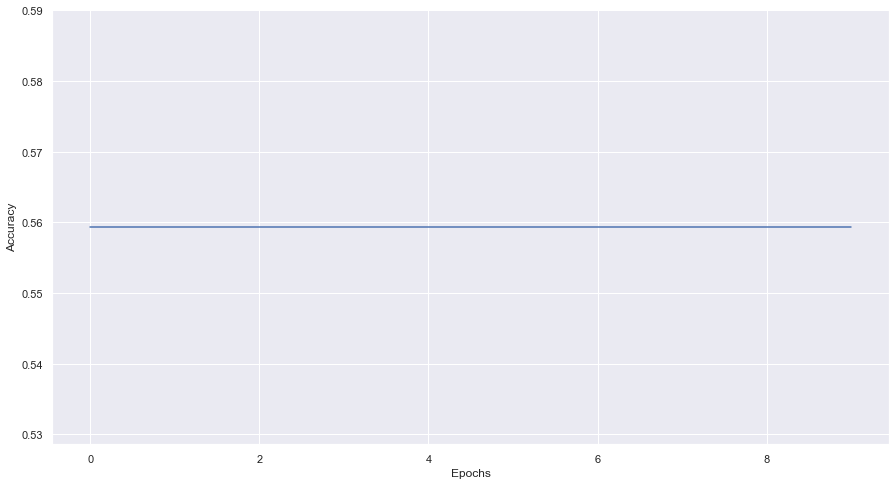

In [15]:
ann.view_accuracyEpoch()

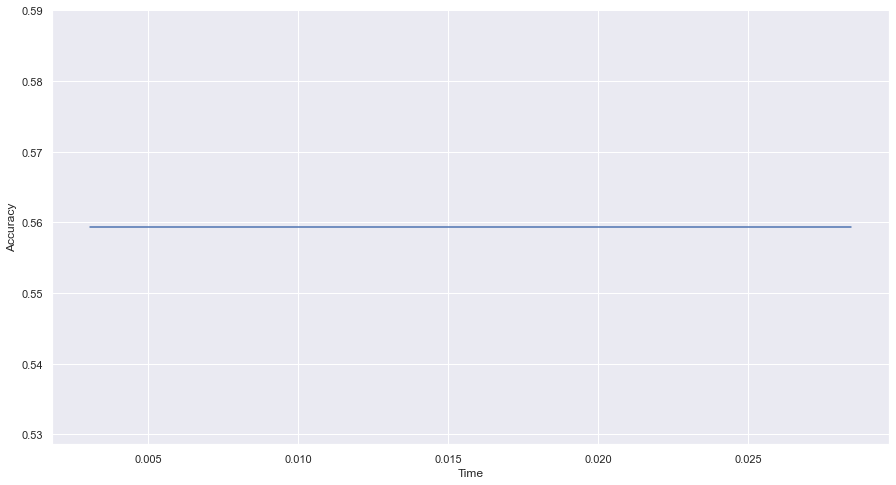

In [16]:
ann.view_accuracyTime()

In [17]:
# Changing Layer Structure
annLayers = copy.deepcopy(ann)
annLayers.change_layers([4,8,8,2])

Old test accuracy: 0.559375
New test accuracy: 0.8145833333333333


In [18]:
# Current Hyperparameters
annLayers

ANN Hyperparameters
Layers: [4, 8, 8, 2]
Iterations: 10                 
Learning rate: 1
Activations: ['relu', 'relu', 'sigmoid']

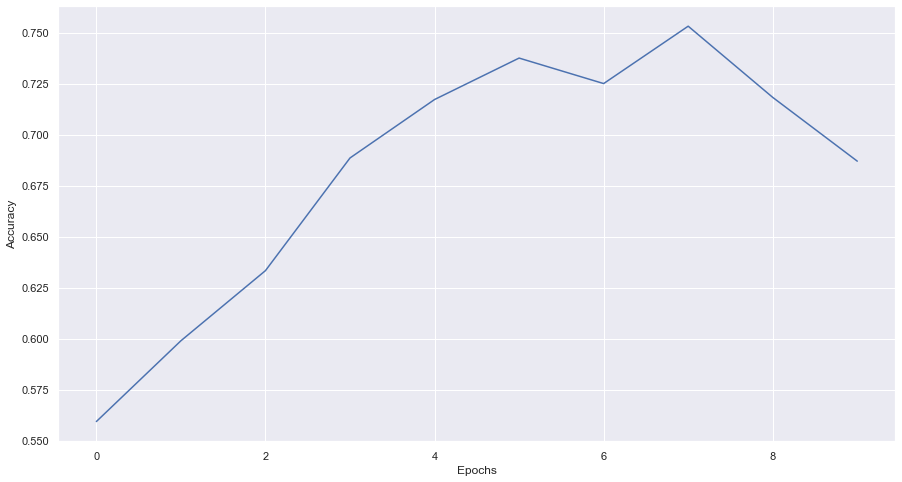

In [19]:
annLayers.view_accuracyEpoch()

In [20]:
# Change activation functions
annActs = copy.deepcopy(ann)
ann.change_activations(['sigmoid', 'sigmoid','sigmoid'])

Old test accuracy: 0.559375
New test accuracy: 0.559375


In [21]:
# Current Hyperparameters
annActs

ANN Hyperparameters
Layers: [4, 3, 2, 2]
Iterations: 10                 
Learning rate: 1
Activations: ['relu', 'relu', 'sigmoid']

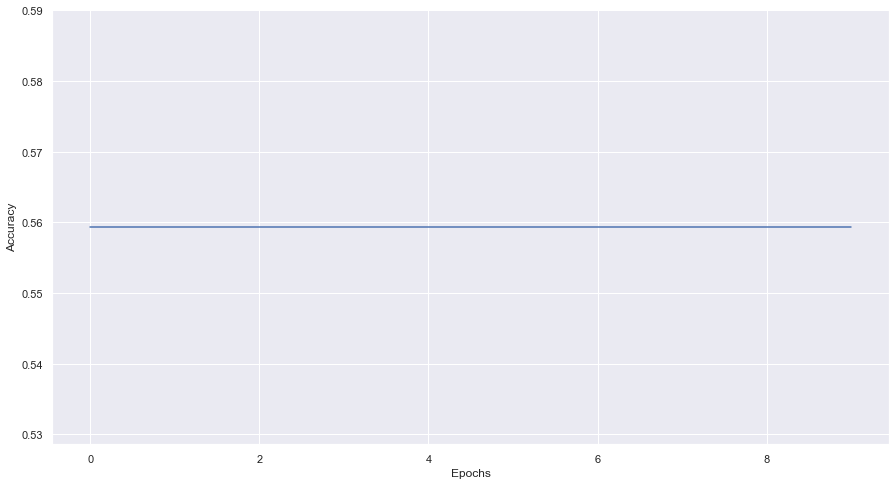

In [22]:
annActs.view_accuracyEpoch()

In [23]:
# Change Number of Iterations
annEpochs = copy.deepcopy(ann)
annEpochs.change_epochs(50)

Old test accuracy: 0.559375
New test accuracy: 0.9541666666666667


In [24]:
annEpochs

ANN Hyperparameters
Layers: [4, 3, 2, 2]
Iterations: 50                 
Learning rate: 1
Activations: ['sigmoid', 'sigmoid', 'sigmoid']

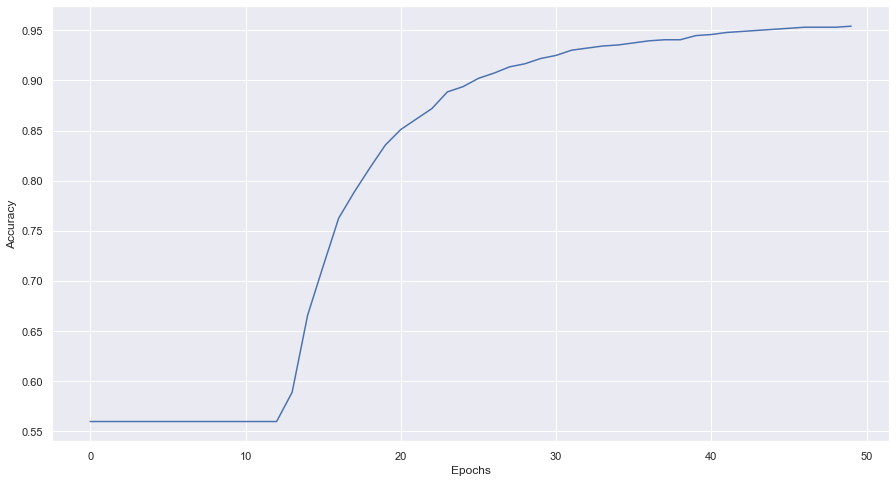

In [25]:
annEpochs.view_accuracyEpoch()

In [36]:
# Change Learning rate
annAlpha = copy.deepcopy(ann)
ann.change_learningRate(0.05)

Old test accuracy: 0.559375
New test accuracy: 0.559375


In [37]:
annAlpha

ANN Hyperparameters
Layers: [4, 3, 2, 2]
Iterations: 10                 
Learning rate: 0.05
Activations: ['sigmoid', 'sigmoid', 'sigmoid']

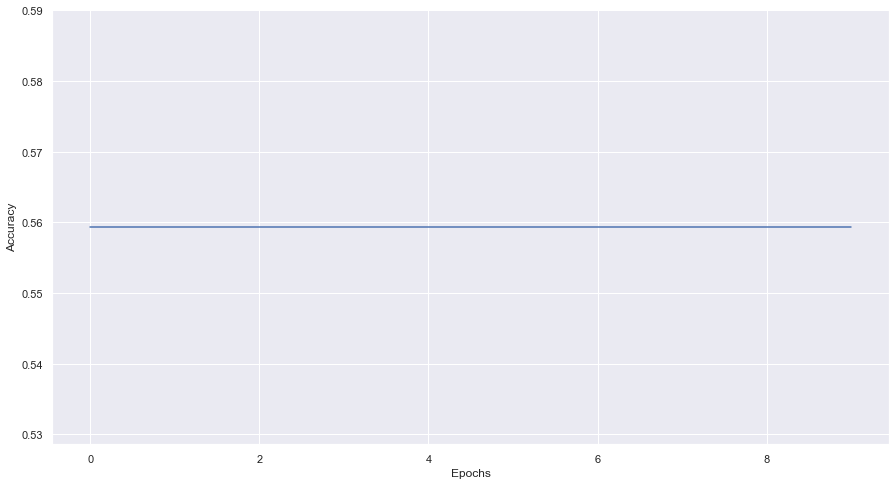

In [28]:
annAlpha.view_accuracyEpoch();

#### Observations
1. Layer structure, more specefically the number of neurons in each layer appears to have a significant positive effect on accuracy.
2. Activation functions appear to make no difference.
3. Epochs appear to have a strong positive effect on accuracy.
4. Learning rate appears to make no difference, which is rather surprising.

**We will conduct more training for random values of Layer Structure, Epochs and Learning Rate to estimate their (sample) mean and standard deviation.**